### Introduction to Flow Matching 
Flow matching is a technique of training Diffusion Models (diffusion models only have score matching or flow matching these two methods).  
  
The goal of flow matching is that if we have a training set which models an intractable probability distribution $P_{data}$ (given some x, the y is the training example), how do we let the model learn the probability distribution (this is the motivation behind every generative model). Diffusion models accomplish this by starting from an initial distribution $P_{init}$, which is a lot simpler and we know (i.e. a Gaussian Distribution). How do we go from the initial distribution to the data distribution?  
  
This led to the use of Stochastic Differential Equations (SDE) and Ordinary Differential Equations (ODE) --> Mathematical formulation of this problem. We can imagine starting with initial noise from $P_{init}$ which can be a random vector generated from a Gaussian or other simple distributions (the choice of this distribution matters for calculations). And the process of going to the true data distribution as the vector changing and going to different directions and eventually settling at the correct positions. This is exactly the process of Differential Equations.  
  
The initial noise can be seen as the initial condition of a DE $X_{0} \sim P_{init}$, deciding where to go is determined by Vector Field $u_t$, and the trajectory which is a solution to the Differential Equation, which is an instance of probability distribution modeled by the model.  

To go from noise to data distribution, we have to define how vectors move or how do they decide where to move. This process is $dX_t$. If we figure out how to model $dX_t$ which is often intractable, we figure out how to arrive at $P_{data}$. Modeling $dX_t$ is the diffusion process. 
  
The diffusion process is backed by SDE and ODE, and this is where score matching and flow matching originated from. In ODE, $dX_t = u_t(X_t)dt$, and in SDE, this form is added with random noise(i.e. from Brownian Motion) $dX_t= u_t(X_t) dt + \sigma_t dW_t$. We can see that SDE's $dX_t$ contains ODE's, this also draws parallel to the similar form of score matching with flow matching.   
  
Next step is how to calculate the vector field of ODE and SDE. 

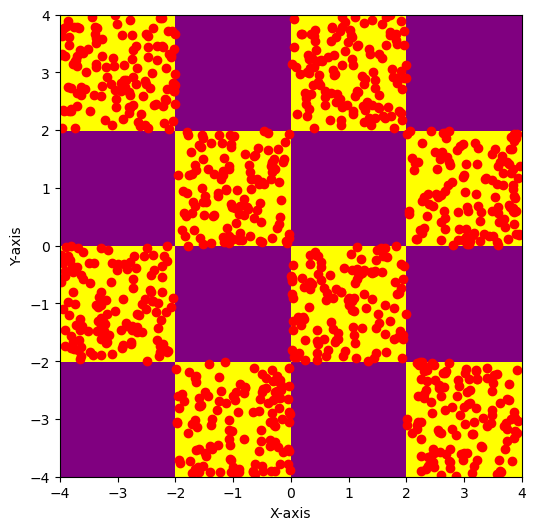

In [2]:
# data construction 
# construct different blocks of points as the ground truth data distribution, to do that, get points that only exist in box
import tqdm
import math
import torch
import numpy as np
from torch import nn
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap

# Parameters
N = 1000  # Number of points to sample
x_min, x_max = -4, 4
y_min, y_max = -4, 4
resolution = 100  # Resolution of the grid

# Create the grid
x = np.linspace(x_min, x_max, resolution)
y = np.linspace(y_min, y_max, resolution)
X, Y = np.meshgrid(x, y)

# Checkerboard pattern
length = 4
checkerboard = np.indices((length, length)).sum(axis=0) % 2

# Sample points in regions where checkerboard pattern is 1
sampled_points = []
while len(sampled_points) < N:
    # Randomly sample a point within the x and y range
    x_sample = np.random.uniform(x_min, x_max)
    y_sample = np.random.uniform(y_min, y_max)
    
    # Determine the closest grid index
    i = int((x_sample - x_min) / (x_max - x_min) * length)
    j = int((y_sample - y_min) / (y_max - y_min) * length)
    
    # Check if the sampled point is in a region where checkerboard == 1
    if checkerboard[j, i] == 1:
        sampled_points.append((x_sample, y_sample))

# Convert to NumPy array for easier plotting
sampled_points = np.array(sampled_points)

# Plot the checkerboard pattern
plt.figure(figsize=(6, 6))
plt.imshow(checkerboard, extent=(x_min, x_max, y_min, y_max), origin="lower", cmap=ListedColormap(["purple", "yellow"]))

# Plot sampled points
plt.scatter(sampled_points[:, 0], sampled_points[:, 1], color="red", marker="o")
plt.xlabel("X-axis")
plt.ylabel("Y-axis")
plt.show()

#### Model 
Based on the math derivations, the model will model the vector field $u_t$ (outputs a value) and compares the loss with the vector field value of the original conditional vector field $u_t(x|z)$  
  
The conditional vector field value is approximated to be (z*$\epsilon$). We will implement our parameter vector field using MLP to generate the vector direction, and compare the model output with the conditional vector field value.   
  
At each training step, we will sample a random training sample as $z$, and a Gaussian noise $\epsilon$ from a Gaussian distribution. Then we will get the output from the MLP, we will compare the output to construct the loss function. A very good MLP model will "guide" the initial point to the correct position in the actual data distribution.   
  
Notice that our model tries to model $u_t$, this is not like a discriminative or other generative models like VAE or GAN, we don't get the eventual output directly. We will have to take multiple steps from the original voice and follow the direction/derivative (output of MLP), and eventually land at the final at $P_{data}$ points.  
  
The number of steps taken is empirically determined. If we have too many steps taken, the output would still be at the correct stop (MLP should output a direction change of close to 0)

In [4]:
# model 
class Layer(nn.Module):
    def __init__(self, channels=512): 
        super().__init__() 
        self.fc= nn.Linear(channels, channels)
        self.act= nn.ReLU() 
    def forward(self,x): 
        return self.act (self.fc(x))
class MLP(nn.Module):
    # our original data is of size 2. We will project it twice to get the output 
    def __init__(self, channels_data=2, layers=5, channels=512, channels_t=512):
        super().__init__()
        self.channels_t = channels_t
        self.in_projection = nn.Linear(channels_data, channels)
        self.t_projection = nn.Linear(channels_t, channels)
        self.blocks = nn.Sequential(*[
            Layer(channels) for _ in range(layers)  # repeat the layer a few times 
        ])
        self.out_projection = nn.Linear(channels, channels_data)

    def gen_t_embedding(self, t, max_positions=10000):
        t = t * max_positions
        half_dim = self.channels_t // 2
        emb = math.log(max_positions) / (half_dim - 1)
        emb = torch.arange(half_dim, device=t.device).float().mul(-emb).exp()
        emb = t[:, None] * emb[None, :]
        emb = torch.cat([emb.sin(), emb.cos()], dim=1)
        if self.channels_t % 2 == 1:  # zero pad
            emb = nn.functional.pad(emb, (0, 1), mode='constant')
        return emb

    def forward(self, x, t):
        x = self.in_projection(x)
        t = self.gen_t_embedding(t)
        t = self.t_projection(t)
        x = x + t 
        x = self.blocks(x)
        x = self.out_projection(x)
        return x

In [5]:
model= MLP(layers=5, channels=512)
optim = torch.optim.Adam(model.parameters(), lr=1e-4)

#### Training 
Our data is 2 dimensional (cartesian plane) so we will output 2 coordinates.  
  
We will first randomly sample z from the data set

In [31]:
data= torch.Tensor(sampled_points)  # true data distribution 
training_steps= 100000 
batch_size=64 
pbar = tqdm.tqdm(range(training_steps))
losses = []
for i in pbar: 
    rand_idx= torch.randint(data.size(0), (batch_size,))    # randomly get batch_size list of indices from 1000 # of training samples
    z= data[rand_idx]   # randomly get our data points from true data distribution 
    eps= torch.randn_like(z) # create noise from similar with the true data 
    target= z-eps    # the ground truth label is the close form approximation of the target vector field 
    t= torch.randn(z.size(0))  # sample a vector of exactly the same number of samples (so going from beginning to end is like 0->1 )
    xt= (1-t[:,None]) * eps + t[:,None] * z # close form approximation of our sampled noise to be the vector. Our vector has to be this way for calculations to work out 
    pred= model(xt,t)
    loss= ((target-pred)**2).mean() # mean square error loss 
    loss.backward()
    optim.step() 
    optim.zero_grad() 
    pbar.set_postfix(loss=loss.item())
    losses.append(loss.item())

100%|██████████| 100000/100000 [1:25:18<00:00, 19.54it/s, loss=1.39]  


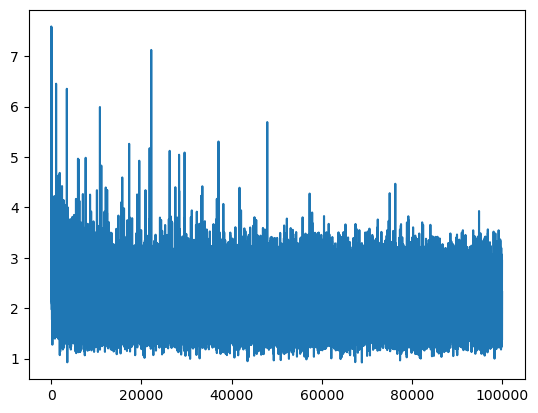

In [32]:
plt.plot(losses)

#### Sampling 
After training, the last step is sampling from our generated data distribution. We can understand it as our model has learned the data distribution of the training data, so given the steps from $t=0$ -> 1, the model can output the correct direction  
  
To do sampling, start with a random noise (from the same distribution $P_{init}$), define a step size, then run Euler Method based sampling. So at each step, run the model to get the output at the next step, and repeat this process. 

In [ ]:
torch.manual_seed(42)
model.eval().requires_grad_(False)
# define our vector 
xt= torch.randn(1000,2) # sample a random noise 
steps= 1000 
plot_every= 100 
for i,t in enumerate(torch.linspace(0,1,steps=steps), start=1):     # define our step size to be 1000 from t=0 to 1 
    pred= model(xt, t.expand(xt.size(0)))    # pass in each time 
    xt=xt+ (1/steps) * pred     # update to the next position 
    if i % plot_every == 0:
        plt.figure(figsize=(6, 6))
        plt.scatter(sampled_points[:, 0], sampled_points[:, 1], color="red", marker="o")
        plt.scatter(xt.cpu().numpy()[:, 0], xt.cpu().numpy()[:, 1], color="black", marker="o")
        plt.show()
print("Sampling finished")